In [1]:
import os
import ee
import io
import time
import requests
import datetime
import itertools
import urllib.request

import numpy as np
import pandas as pd
import rsfuncs as rs
import geopandas as gp
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

ee.Initialize()

%load_ext autoreload
%autoreload 2

In [2]:
def get_ims(dataset, startdate,enddate, area, scale_factor, return_dates = False, table = False, monthly_mean = False,  monthly_sum = False):

    '''
    Returns gridded images for EE datasets 
    '''

    if monthly_mean:
        if monthly_sum:
            raise ValueError("cannot perform mean and sum reduction at the same time")              

    ImageCollection = dataset[0]
    var = dataset[1]
    native_res = dataset[3]

    dt_idx = pd.date_range(startdate,enddate, freq='MS')
    ims = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()

    # TODO: Make this one loop ?

    print("processing:")
    print("{}".format(ImageCollection.first().getInfo()['id']))

    for i in tqdm(num_steps):

        start = ee.Date(startdate).advance(i, 'month')
        end = start.advance(1, 'month');

        if monthly_mean:
            im1 = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).mean().set('system:time_start', end.millis())
            im = ee.ImageCollection(im1)
        elif monthly_sum:
            im1 = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).sum().set('system:time_start', end.millis())
            im = ee.ImageCollection(im1)
        else:
            im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).set('system:time_start', end.millis())

        # This try / catch is probably not great, but needs to be done for e.g. grace which is missing random months 
        try:
            result = im.getRegion(area,native_res,"epsg:4326").getInfo()
            ims.append(result)
        except:
            continue


    results = []
    dates = []

    print("postprocesing")

    for im in tqdm(ims):
        header, data = im[0], im[1:]

        df = pd.DataFrame(np.column_stack(data).T, columns = header)
        df.latitude = pd.to_numeric(df.latitude)
        df.longitude = pd.to_numeric(df.longitude)
        df[var] = pd.to_numeric(df[var])
        
        images = []

        for idx,i in enumerate(df.id.unique()):

            t1 = df[df.id==i]
            arr = rs.array_from_df(t1,var)
            arr[arr == 0] = np.nan
            images.append(arr*scale_factor)# This is the only good place to apply the scaling factor. 

            if return_dates:
                date = df.time.iloc[idx]
                dates.append(datetime.datetime.fromtimestamp(date/1000.0))

        results.append(images) 
        
    return [item for sublist in results for item in sublist] 

def get_scale_factor(area, var = "SCALE_FACTOR"):
    img = ee.ImageCollection(ee.Image("NASA/GRACE/MASS_GRIDS/LAND_AUX_2014").select(var).clip(area)).getRegion(area,50000,"epsg:4326").getInfo()

    header, data = img[0], img[1:]

    df = pd.DataFrame(np.column_stack(data).T, columns = header)
    df.latitude = pd.to_numeric(df.latitude)
    df.longitude = pd.to_numeric(df.longitude)
    df[var] = pd.to_numeric(df[var])

    sfim = []
    for idx,i in enumerate(df.id.unique()):

        t1 = df[df.id==i]
        arr = rs.array_from_df(t1,var)
        arr[arr == 0] = np.nan
        sfim.append(arr)
    return sfim[0]


def get_grace_unc(dataset, startdate, enddate, area):

    col = dataset[0]
    var = "uncertainty"
    scaling_factor = dataset[2]
    
    dt_idx = pd.date_range(startdate,enddate, freq='MS')
    sums = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()

    print("processing:")
    print("{}".format(col.first().getInfo()['id']))

    for i in tqdm(num_steps):
        
        start = ee.Date(startdate).advance(i, 'month')
        end = start.advance(1, 'month');

        try:
            im = ee.ImageCollection(col).select(var).filterDate(start, end).sum().set('system:time_start', end.millis())
            t2 = im.multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-6) # Multiply by pixel area in km^2

            scale = t2.projection().nominalScale()
            sumdict  = t2.reduceRegion(
                    reducer = ee.Reducer.sum(),
                    geometry = area,
                    scale = scale)

            result = sumdict.getInfo()[var] * 1e-5# cm to km
            sums.append(result)
        except:
            sums.append(np.nan) # If there is no grace data that month, append a np.nan 
    
    sumdf = pd.DataFrame(np.array(sums), dt_idx+MonthEnd(0))
    sumdf.columns = [var]
    df = sumdf.astype(float)
    
    return df

In [3]:
# Select area
shp = gp.read_file("../shape/argus_grace.shp")
area = rs.gdf_to_ee_poly(shp)

# Load data
data = rs.load_data()

# Set GRACE study period 
strstart = '2002-04-01'
strend = '2017-03-31'

startgrace = datetime.datetime.strptime(strstart, "%Y-%m-%d")
endgrace = datetime.datetime.strptime(strend, "%Y-%m-%d")

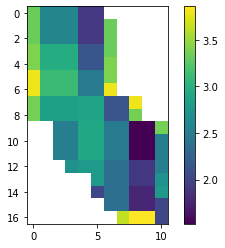

In [4]:
# Plot the spatial scaling coefficients for sanity 
scaling_factor = get_scale_factor(area)
plt.imshow(scaling_factor)
plt.colorbar()

# rs.write_raster(scaling_factor, shp, "grace_scaling_factor.tif")

In [5]:
# Get grace products
cri = rs.get_grace(data['cri'], startgrace, endgrace, area)
mas = rs.get_grace(data['mas'], startgrace, endgrace, area)
gfz = rs.get_grace(data['gfz'], startgrace, endgrace, area)
csr = rs.get_grace(data['csr'], startgrace, endgrace, area)
jpl = rs.get_grace(data['jpl'], startgrace, endgrace, area)

processing:
NASA/GRACE/MASS_GRIDS/MASCON_CRI/20020331_20020429



processing:
NASA/GRACE/MASS_GRIDS/MASCON/20020331_20020429



processing:
NASA/GRACE/MASS_GRIDS/LAND/20020401_20020430



processing:
NASA/GRACE/MASS_GRIDS/LAND/20020401_20020430



processing:
NASA/GRACE/MASS_GRIDS/LAND/20020401_20020430


In [6]:
# Get uncertainty
cri_unc = get_grace_unc(data['cri_unc'], startgrace, endgrace, area)
mas_unc = get_grace_unc(data['mas_unc'], startgrace, endgrace, area)

processing:
NASA/GRACE/MASS_GRIDS/MASCON_CRI/20020331_20020429



processing:
NASA/GRACE/MASS_GRIDS/MASCON/20020331_20020429


In [7]:
mas_upper = pd.DataFrame(mas['lwe_thickness'] + mas_unc['uncertainty'], columns = ['mas_upper'])
mas_lower = pd.DataFrame(mas['lwe_thickness'] - mas_unc['uncertainty'], columns = ['mas_lower'])

In [8]:
cri_upper = pd.DataFrame(cri['lwe_thickness'] + cri_unc['uncertainty'], columns = ['cri_upper'])
cri_lower = pd.DataFrame(cri['lwe_thickness'] - cri_unc['uncertainty'], columns = ['cri_lower'])

In [9]:
# Now the Hydrology data 

In [10]:
# Add an extra month beforehand, since we are differencing from the starting point, (e.g. dS/dt) 
strstart = '2002-03-01'
strend = '2017-03-31'

startdate = datetime.datetime.strptime(strstart, "%Y-%m-%d")
enddate = datetime.datetime.strptime(strend, "%Y-%m-%d")


In [11]:
# Soil moisture
tc_sm = rs.calc_monthly_mean(data['tc_sm'], startdate, enddate, area)
tc_sm.rename(columns = {"soil" : "tc_sm"}, inplace = True)

processing:
IDAHO_EPSCOR/TERRACLIMATE/195801


In [12]:

# Get alldepths gldas 
gldas_gsm1 = rs.calc_monthly_mean(data['gsm1'], startdate, enddate, area)
gldas_gsm2 = rs.calc_monthly_mean(data['gsm2'], startdate, enddate, area)
gldas_gsm3 = rs.calc_monthly_mean(data['gsm3'], startdate, enddate, area)
gldas_gsm4 = rs.calc_monthly_mean(data['gsm4'], startdate, enddate, area)

# Compile GLDAS
gldas_sm = pd.DataFrame(pd.concat([gldas_gsm1,gldas_gsm2,gldas_gsm3,gldas_gsm4], axis = 1).sum(axis =1))
gldas_sm.columns=['sm_gldas']



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000


In [13]:
# Get smos / smap data 
smos_ssm = rs.calc_monthly_mean(data['smos_ssm'], "2010-01-01", enddate, area)
smos_susm = rs.calc_monthly_mean(data['smos_susm'],"2010-01-01", enddate, area)
smos_sm = pd.concat([smos_ssm, smos_susm], axis = 1).sum(axis =1)

smap_ssm = rs.calc_monthly_mean(data['smap_ssm'], '2015-04-01', '2019-12-31', area)
smap_susm = rs.calc_monthly_mean(data['smap_susm'],'2015-04-01', '2019-12-31', area)
smap_sm = pd.concat([smap_ssm, smap_susm], axis = 1).sum(axis =1)

# Make dfs and rename cols 
smap_sm = pd.DataFrame(smap_sm, columns = ['sm_smap'])
smos_sm = pd.DataFrame(smos_sm, columns = ['sm_smos'])

processing:
NASA_USDA/HSL/soil_moisture/NASA_USDA_SM20100113_20100115



processing:
NASA_USDA/HSL/soil_moisture/NASA_USDA_SM20100113_20100115



processing:
NASA_USDA/HSL/SMAP_soil_moisture/NASA_USDA_SMAP_SM20150402_20150404



processing:
NASA_USDA/HSL/SMAP_soil_moisture/NASA_USDA_SMAP_SM20150402_20150404


In [14]:
# SWE-E
fldas_swe = rs.calc_monthly_mean(data['fldas_swe'], startdate,enddate, area)
gldas_swe = rs.calc_monthly_mean(data['gldas_swe'], startdate,enddate, area)
tc_swe = rs.calc_monthly_mean(data['tc_swe'], startdate,enddate, area)
dmet_swe = rs.calc_monthly_mean(data['dmet_swe'], startdate,enddate, area)


processing:
NASA/FLDAS/NOAH01/C/GL/M/V001/198201



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000



processing:
IDAHO_EPSCOR/TERRACLIMATE/195801



processing:
NASA/ORNL/DAYMET_V3/19800101


In [15]:
# Local swe data
lrm_swe = rs.get_lrm_swe("../shape/argus_grace.shp", data_dir = "/Users/aakash/Desktop/SierraSheds/data/LRM_SWE_monthly/")
snodas_swe = rs.get_snodas_swe("../shape/argus_grace.shp", data_dir ="/Users/aakash/Desktop/SatDat/GRACE/SNODAS_GRACE_processed/" )


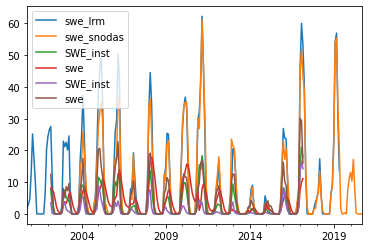

In [16]:
fig, ax = plt.subplots()
lrm_swe.plot(ax = ax)
snodas_swe.plot(ax = ax)
fldas_swe.plot(ax = ax)
dmet_swe.plot(ax = ax)
gldas_swe.plot(ax = ax)
tc_swe.plot(ax = ax)

In [17]:
# Rename swe columns
dmet_swe.rename(columns = {'swe' : 'swe_dmet'}, inplace = True)
fldas_swe.rename(columns= {'SWE_inst':'swe_fldas'}, inplace = True)
gldas_swe.rename(columns = {'SWE_inst':'swe_gldas'}, inplace = True)
tc_swe.rename(columns = {'swe':'swe_tc'}, inplace = True)


In [18]:
# Get the Reservoir data in the grace domain 

shpfile = "../shape/argus_grace.shp"

print("**** Begin Fetching CDEC Reservoir Storage Data for {} ****".format(shpfile))

# Read the shapefile 
gdf = gp.read_file(shpfile)

# Spatial join cdec reservoirs to supplied gdf 
reservoirs = gp.read_file("../shape/cdec_reservoirs.shp")
within_gdf = gp.sjoin(reservoirs, gdf, how='inner', op='within')

# Download Storage (SensorNums = 15) data by query str:
start = datetime.datetime(1997, 1, 1)
end = datetime.datetime(2020, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

data = {}

for i in tqdm(within_gdf.ID):
    print("processing " + i )
    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=1997-01-01&End=2020-01-01".format(i)
    urlData = requests.get(url).content
    resdf = pd.read_csv(io.StringIO(urlData.decode('utf-8')))

    if resdf.empty:
        pass
    else:
        data[i] = resdf

storage = []
for k,v in data.items():
    dat = pd.to_numeric(data[k].VALUE, errors = "coerce")
    if not len(dat) < len(dt_idx):
        storage.append(pd.to_numeric(data[k].VALUE, errors = "coerce"))

storage_sum = np.nansum(np.column_stack(storage), axis = 1) * 1.23348e-6 # acre ft to km^3
Sres = pd.DataFrame(zip(dt_idx,storage_sum), columns = ['date',"Sres"])
Sres.set_index('date', inplace = True)

print("Mean reservoir storage = {} km^3".format(np.mean(Sres)))

print("Reservoir Storage DONE ====================================== ")



**** Begin Fetching CDEC Reservoir Storage Data for ../shape/argus_grace.shp ****


processing ABY
processing ADI
processing ADN
processing AGP
processing APH
processing ALT
processing AMF
processing APS
processing APU
processing ANT
processing ANR
processing ATS
processing ATP
processing AVL
processing ASH
processing ASM
processing ATW
processing ABR
processing AUB
processing BDF
processing BFK
processing BAL
processing BNG
processing BHM
processing BBS
processing CFW
processing BRM
processing BV1
processing BMD
processing BRD
processing BHV
processing BEM
processing BNH
processing BER
processing BGC
processing BFT
processing BGM
processing BMS
processing BP1
processing BP2
processing BP3
processing BWH
processing BGH
processing BIS
processing BSP
processing BSH
processing BLB
processing BLS
processing BCB
processing BMN
processing BLD
processing BLC
processing BYM
processing BLU
processing BLK
processing BCA
processing BOC
processing BDE
processing BNP
processing BNM
processing BOW
processing BOL
processing BOM
processing BWN
processing BWR
processing BPT
processing

processing 3LK
processing 3RV
processing TCP
processing TNM
processing TGP
processing TCR
processing TRG
processing TRL
processing CLE
processing TNL
processing TRF
processing TKT
processing TKE
processing 6SI
processing TUL
processing STU
processing TUM
processing TLG
processing TLC
processing TND
processing UNV
processing UBC
processing UCP
processing UKR
processing UTR
processing UWD
processing VNN
processing VNT
processing VGL
processing VRG
processing VSL
processing VLC
processing WBM
processing WR2
processing WRN
processing WSC
processing WVR
processing WBB
processing WPK
processing WFC
processing WPT
processing WWR
processing WHN
processing WHE
processing WHK
processing WHI
processing WLF
processing WLW
processing WSN
processing WSD
processing WLC
processing WDH
processing WDL
processing WRG
processing YSV
processing YRK
processing YBP
processing YRS

Mean reservoir storage = Sres    30.131982
dtype: float64 km^3
Reservoir Storage DONE ====================================== 


In [19]:
# Calc means for each station with data
stn_means = {}
for k,v in data.items():
    stn_means[k] = np.nanmean(pd.to_numeric(v.VALUE, errors = "coerce"))* 1.23348e-6 # acre ft to km^3

# Reassemble a gdf to write out 
sdfs=[]
for k,v in stn_means.items():
    sdf = within_gdf[within_gdf['ID'] == k]
    sdf.loc[:,'Smean'] = v
    sdfs.append(sdf)
    

/anaconda3/envs/pysheds/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/pysheds/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
# Write reservoirs in the grace domain
pd.concat(sdfs).to_file("../shape/reservoirs_grace.shp")

In [21]:
# Rename all df columns and format for ensemble runs 

# SWE 
swecoldict = {'swe_gldas':'GLDAS', 
                'swe_fldas':'FLDAS',  
                'swe_dmet':"Daymet",
                'swe_tc':'TC',
                'swe_lrm': "UCB LRM",
                'swe_snodas': "SNODAS"}
swedf = pd.concat([dmet_swe,gldas_swe,fldas_swe,tc_swe,lrm_swe,snodas_swe], axis = 1)
swedf.rename(columns = swecoldict, inplace = True)

# SM
smcoldict = {   'sm_gldas':'GLDAS', 
                'tc_sm':'TC',
                'sm_smos': "SMOS",
                'sm_smap': "SMAP"}
smdf = pd.concat([gldas_sm,tc_sm,smos_sm,smap_sm], axis = 1)
smdf.rename(columns = smcoldict, inplace = True)


# Grace
cri.rename(columns = {'lwe_thickness': 'lwe_thickness_cri'}, inplace = True)
mas.rename(columns = {'lwe_thickness': 'lwe_thickness_mas'}, inplace = True)
grdf = pd.concat([cri,mas,jpl,gfz,csr], axis = 1)

gm_col_dict = {'lwe_thickness_cri':'GLDAS', 
                'lwe_thickness_cri':'FLDAS',  
                'lwe_thickness_cri':"Daymet",
                'lwe_thickness_cri':'TC',
                'lwe_thickness_cri': "UCB LRM"}

cri.rename(columns = {'lwe_thickness': 'lwe_thickness_cri'}, inplace = True)
mas.rename(columns = {'lwe_thickness': 'lwe_thickness_mas'}, inplace = True)
grdf = pd.concat([cri,cri_lower, cri_upper,mas,mas_lower, mas_upper,jpl,gfz,csr], axis = 1)

gm_col_dict = { 'lwe_thickness_cri':'CRI', 
                'lwe_thickness_mas':'MAS',  
                'lwe_thickness_jpl':"JPL",
                'lwe_thickness_gfz':'GFZ',
                'lwe_thickness_csr':"CSR",
                'cri_lower' : "CRI Lower Bound",
                'cri_upper' : "CRI Upper Bound",
                'mas_upper' : "MAS Upper Bound",
                'mas_lower' : "MAS Lower Bound",
              }

grdf.rename(columns = gm_col_dict, inplace = True)

In [22]:
# Make the ensemble 
swelist = ['UCB LRM','SNODAS', "TC","FLDAS"]
smlist = ['SMOS','SMAP','TC','GLDAS']
glist = ["CRI Upper Bound", "CRI", "CRI Lower Bound"]

combolist = list(itertools.product(*[swelist,smlist,glist]))
print("Ensemble has {} members".format(str(len(combolist))))

Ensemble has 48 members


In [30]:
grace_ens = []
for swe,sm,grace in combolist:
    ds = (grdf[grace] - swedf[swe].diff() - smdf[sm].diff() - Sres['Sres'].diff())
    end = grdf['CRI'].dropna().index[-1]
    mask = (ds.index < end)
    grace_ens.append(ds.loc[mask].interpolate(method="polynomial", order = 3))

/anaconda3/envs/pysheds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-31-3da92dd03d48>:10: RuntimeWarning: Mean of empty slice
  ax1.plot(grace_ens[0].index,np.nanmean(np.vstack(grace_ens)/ 155000 * 1e6, axis = 0), linewidth = 2, color = 'red')
<ipython-input-31-3da92dd03d48>:21: RuntimeWarning: All-NaN slice encountered
  p25 = np.nanmin(np.vstack(grace_ens), axis =0)
<ipython-input-31-3da92dd03d48>:22: RuntimeWarning: All-NaN slice encountered
  p75 = np.nanmax(np.vstack(grace_ens), axis =0)
<ipython-input-31-3da92dd03d48>:23: RuntimeWarning: Mean of empty slice
  ax2.plot(grace_ens[0].index,np.nanmean(np.vstack(grace_ens), axis = 0), alpha = 0)


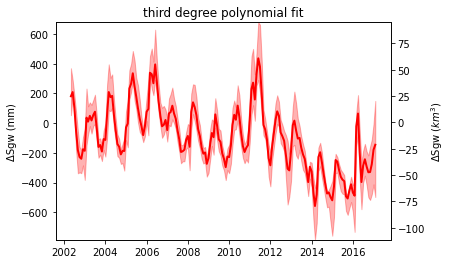

In [31]:
fig, ax1 = plt.subplots()

# Uncomment to plot all ensembles
for d in grace_ens:
    ax1.plot(d / 155000 * 1e6, alpha = 0.0, color = 'gray')

p25 = np.nanquantile(np.vstack(grace_ens)/ 155000 * 1e6,0.15, axis =0)
p75 = np.nanquantile(np.vstack(grace_ens)/ 155000 * 1e6,0.85, axis =0)
    
ax1.plot(grace_ens[0].index,np.nanmean(np.vstack(grace_ens)/ 155000 * 1e6, axis = 0), linewidth = 2, color = 'red')
ax1.set_ylabel('ΔSgw (mm)')
# ax1.set_ylim([np.nanmin(p25),np.nanmax(p75)])

ax2 = ax1.twinx()  

# Uncomment to plot all ensembles
for d in grace_ens:
    ax2.plot(d, alpha = 0.0, color = 'gray')

# 75 th 25th quantile
p25 = np.nanmin(np.vstack(grace_ens), axis =0)
p75 = np.nanmax(np.vstack(grace_ens), axis =0)
ax2.plot(grace_ens[0].index,np.nanmean(np.vstack(grace_ens), axis = 0), alpha = 0)
ax2.fill_between(grace_ens[0].index,p25,p75, alpha = 0.3, color = 'red')

ax2.tick_params(axis='y')
ax2.set_ylabel('ΔSgw ($km^3$)')
ax2.set_ylim([np.nanmin(p25),np.nanmax(p75)])
ax2.set_title("third degree polynomial fit")

plt.show()

/anaconda3/envs/pysheds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-31-433fa95f0bd7>:10: RuntimeWarning: Mean of empty slice
  ax1.plot(grace_ens[0].index,np.nanmean(np.vstack(grace_ens)/ 155000 * 1e6, axis = 0), linewidth = 2, color = 'red')
<ipython-input-31-433fa95f0bd7>:21: RuntimeWarning: All-NaN slice encountered
  p25 = np.nanmin(np.vstack(grace_ens), axis =0)
<ipython-input-31-433fa95f0bd7>:22: RuntimeWarning: All-NaN slice encountered
  p75 = np.nanmax(np.vstack(grace_ens), axis =0)
<ipython-input-31-433fa95f0bd7>:23: RuntimeWarning: Mean of empty slice
  ax2.plot(grace_ens[0].index,np.nanmean(np.vstack(grace_ens), axis = 0), alpha = 0)


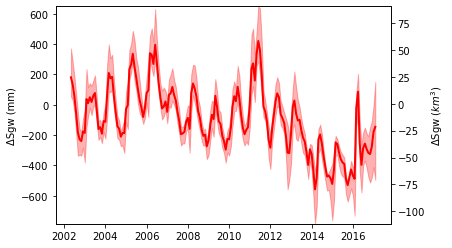

In [31]:
fig, ax1 = plt.subplots()

# Uncomment to plot all ensembles
for d in grace_ens:
    ax1.plot(d / 155000 * 1e6, alpha = 0.0, color = 'gray')

p25 = np.nanquantile(np.vstack(grace_ens)/ 155000 * 1e6,0.15, axis =0)
p75 = np.nanquantile(np.vstack(grace_ens)/ 155000 * 1e6,0.85, axis =0)
    
ax1.plot(grace_ens[0].index,np.nanmean(np.vstack(grace_ens)/ 155000 * 1e6, axis = 0), linewidth = 2, color = 'red')
ax1.set_ylabel('ΔSgw (mm)')
# ax1.set_ylim([np.nanmin(p25),np.nanmax(p75)])

ax2 = ax1.twinx()  

# Uncomment to plot all ensembles
for d in grace_ens:
    ax2.plot(d, alpha = 0.0, color = 'gray')

# 75 th 25th quantile
p25 = np.nanmin(np.vstack(grace_ens), axis =0)
p75 = np.nanmax(np.vstack(grace_ens), axis =0)
ax2.plot(grace_ens[0].index,np.nanmean(np.vstack(grace_ens), axis = 0), alpha = 0)
ax2.fill_between(grace_ens[0].index,p25,p75, alpha = 0.3, color = 'red')

ax2.tick_params(axis='y')
ax2.set_ylabel('ΔSgw ($km^3$)')
ax2.set_ylim([np.nanmin(p25),np.nanmax(p75)])

plt.show()

In [32]:
grace_df_out = pd.DataFrame([np.nanmin(np.vstack(grace_ens), axis =0), 
                             np.nanmean(np.vstack(grace_ens), axis =0), 
                             np.nanmax(np.vstack(grace_ens), axis =0)]).T
grace_df_out.index = grace_ens[0].index
grace_df_out.columns = ['grace_min', 'grace_mean', 'grace_max']

<ipython-input-32-1884358dece7>:1: RuntimeWarning: All-NaN slice encountered
  grace_df_out = pd.DataFrame([np.nanmin(np.vstack(grace_ens), axis =0),
<ipython-input-32-1884358dece7>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.vstack(grace_ens), axis =0),
<ipython-input-32-1884358dece7>:3: RuntimeWarning: All-NaN slice encountered
  np.nanmax(np.vstack(grace_ens), axis =0)]).T


In [33]:
grace_df_out.dropna().to_csv("../data/grace.csv")